## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import re
import json 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from pprint import pprint

from IPython.display import clear_output

In [2]:
nltk.download('wordnet','/root/nltk_data/')

# Wordnet download is not automatically unzipping the downloaded package.
# Code to do that manually
import zipfile
with zipfile.ZipFile('/root/nltk_data/corpora/wordnet.zip', 'r') as zip_ref:
    zip_ref.extractall('/root/nltk_data/corpora/')
print("Downloaded package successfully unzipped")

[nltk_data] Downloading package wordnet to /root/nltk_data/...
Downloaded package successfully unzipped


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
with open('/kaggle/input/upgrad-nlp-automatic-ticket-classification/complaints-2021-05-14_08_16.json') as f:
    
    # returns JSON object as  
    # a dictionary 
    data = json.load(f)
    df=pd.json_normalize(data)

## Data preparation

In [4]:
df.shape

(78313, 22)

Checking for columns without single values

In [5]:
df.nunique()

_index                                   1
_type                                    1
_id                                  78313
_score                                   1
_source.tags                             3
_source.zip_code                      9442
_source.complaint_id                 78313
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.company_public_response          3
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.sub_issue                      205
_source.consumer_consent_provided        5
dtype: int64

Removing columns that have 1 unique ID (ie, the entire column only have one value) and ID columns

In [6]:
df.drop(columns=['_index','_type','_id','_score','_source.complaint_id'],inplace=True)
df.nunique()

_source.tags                             3
_source.zip_code                      9442
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.company_public_response          3
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.sub_issue                      205
_source.consumer_consent_provided        5
dtype: int64

In [7]:
df.shape

(78313, 17)

In [8]:
# Inspect the dataframe to understand the given data.
df.head()

,_source.tags,_source.zip_code,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#print the column names
df.columns

Index(['_source.tags', '_source.zip_code', '_source.issue',
       '_source.date_received', '_source.state', '_source.consumer_disputed',
       '_source.product', '_source.company_response', '_source.company',
       '_source.submitted_via', '_source.date_sent_to_company',
       '_source.company_public_response', '_source.sub_product',
       '_source.timely', '_source.complaint_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign new column names
df.columns = ['tags','zip_code','issue','date_received','state','consumer_disputed','product',
              'company_response','company','submitted_via','date_sent_to_company','company_public_response','sub_product',
             'timely','complaint_what_happened','sub_issue','consumer_consent_provided']
df.head()

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df.loc[ df['complaint_what_happened'] == '' ] = np.nan

In [12]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,None,104XX,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,None,750XX,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,None,920XX,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [13]:
df.shape

(21072, 17)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements, and tokenize.
def clean_n_tokenize(str_data):
    str_data = str_data.lower()
    str_data = re.sub(r'\[.*\]','',str_data)
    str_data = re.sub(r'[^\w\s]','',str_data)
    str_data = re.sub(r'\b\w*\d\w*\b','',str_data)
    str_data = re.sub(r'\n{2,}','\n',str_data)
    str_data = re.sub(r'\s{2,}',' ',str_data)
    return str_data

In [15]:
# Write POS tagging function
def pos_tag_str(str_data):
    doc = nlp(str_data)
    token_list = []
    pos_list = []
    for token in doc:
        token_list += [token.text]
        pos_list += [token.tag_]
    return token_list,pos_list

In [16]:
#Write your function to Lemmatize the texts
def lemmatize_token_list(token_list, pos_list):
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    
    def get_wordnet_pos(pos_tag):
        if pos_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif pos_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif pos_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif pos_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN
    
    lemmatized_token_list = [ wordnet_lemmatizer.lemmatize(token,pos=get_wordnet_pos(pos)) for token,pos in zip(token_list,pos_list) ]
    return lemmatized_token_list

In [17]:
#Create a dataframe('df_clean') that will have only the complaints, the lemmatized complaints and the complaint after removing POS tags.

df_clean = pd.DataFrame(columns=['raw_complaint', 'lemmatized_complaint_token_list', 'cleaned_complaint_token_list'])
total_rows = df.shape[0]

for idx,row in df.iterrows():
    raw_complaint = row['complaint_what_happened']
    processed_complaint = clean_n_tokenize(raw_complaint)
    complaint_token_list, complaint_pos_list = pos_tag_str(processed_complaint)
    lemmatized_complaint_token_list = lemmatize_token_list(complaint_token_list, complaint_pos_list)
    cleaned_complaint_token_list = [ lemmatized_token \
                                    for lemmatized_token,pos in zip(lemmatized_complaint_token_list,complaint_pos_list) \
                                   if pos=='NN']
    
    df_clean.loc[idx,'raw_complaint'] = raw_complaint
    df_clean.loc[idx,'lemmatized_complaint_token_list'] = lemmatized_complaint_token_list
    df_clean.loc[idx,'cleaned_complaint_token_list'] = cleaned_complaint_token_list
    
    clear_output(wait=True)
    print(f'Completed {idx+1} rows out of {total_rows}')

Completed 21072 rows out of 21072


In [18]:
df_clean.head()

,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, debt, ..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[xxxx, agent, anniversary, date, agent, inform..."
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, try, to, book, a, xxxx, xxxx, tick...","[xxxx, ticket, offer, ticket, card, informatio..."
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, chase, account, fund, chase, bank, accou..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



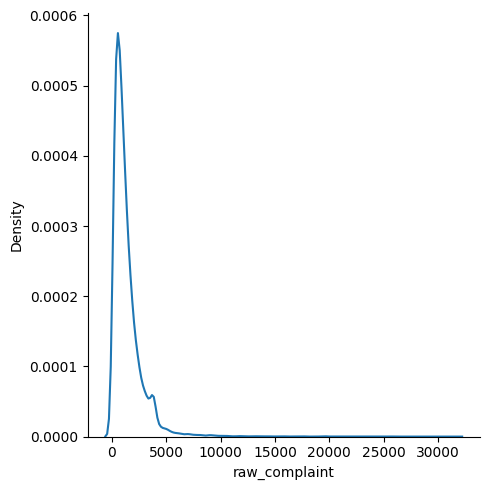

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



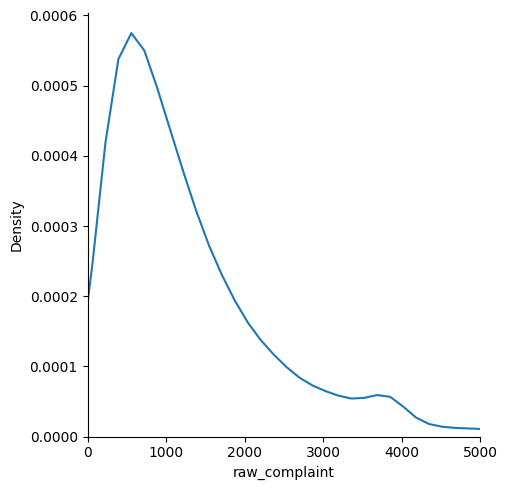

In [19]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_length = df_clean['raw_complaint'].str.len()
char_length.rename('Raw-Complaint-Character-Length')
sns.displot(x=char_length, kind='kde')
plt.show()
sns.displot(x=char_length, kind='kde')
plt.xlim(0,5000)
plt.show()

There seems to be complaints with more than 30000 characters, but the majority complaints have character length lingering somewhere around 1000

#### Find the top 40 words by frequency among all the articles after processing the text.

In [20]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
top_40_words = df_clean.explode('cleaned_complaint_token_list')['cleaned_complaint_token_list'].value_counts()[:40]
top_40_words.name = 'Frequency'
top_40_words

cleaned_complaint_token_list
chase          51808
account        40562
xxxx           34359
credit         32152
card           26459
bank           19524
payment        13938
time           11945
money          11933
loan            9901
information     9617
xxxxxxxx        9283
letter          8369
check           8150
mortgage        7776
number          7722
amount          7572
phone           7375
balance         7087
fraud           6860
customer        6399
company         6394
report          5913
charge          5570
day             5495
business        5428
service         5321
interest        5198
transaction     4877
claim           4802
email           4787
home            4642
branch          4609
dispute         4484
fee             4351
call            4351
complaint       4281
name            4239
date            4196
month           4095
Name: Frequency, dtype: int64

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_30_unigrams():
    top_30_unigram_freq = df_clean.explode('cleaned_complaint_token_list')['cleaned_complaint_token_list'].value_counts()[:30]
    top_30_unigrams = top_30_unigram_freq.index.to_list()
    return top_30_unigrams

In [22]:
#Print the top 10 words in the unigram frequency
top_30_unigrams = get_top_30_unigrams()
top_10_unigrams = top_30_unigrams[:10]
top_10_unigrams

['chase',
 'account',
 'xxxx',
 'credit',
 'card',
 'bank',
 'payment',
 'time',
 'money',
 'loan']

In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_30_bigrams():
    all_words_in_dataset_in_sequence = df_clean.explode('cleaned_complaint_token_list')['cleaned_complaint_token_list'].reset_index(drop=True)

    bigram_df = pd.DataFrame()
    bigram_df['first_word'] = all_words_in_dataset_in_sequence.iloc[:-1].reset_index(drop=True)
    bigram_df['second_word'] = all_words_in_dataset_in_sequence.iloc[1:].reset_index(drop=True)
    bigram_df['bigram'] = bigram_df['first_word'] + ' ' + bigram_df['second_word']
    bigram_frequency = bigram_df['bigram'].value_counts()
    
    top_30_bigrams_frequency = bigram_frequency[:30]
    top_30_bigrams = top_30_bigrams_frequency.index.to_list()
    
    return top_30_bigrams

In [24]:
#Print the top 10 words in the bigram frequency
top_30_bigrams = get_top_30_bigrams()
top_10_bigrams = top_30_bigrams[:10]
top_10_bigrams

['credit card',
 'credit report',
 'chase credit',
 'account chase',
 'chase account',
 'customer service',
 'xxxx xxxx',
 'account account',
 'bank account',
 'chase bank']

In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_30_trigrams():
    all_words_in_dataset_in_sequence = df_clean.explode('cleaned_complaint_token_list')['cleaned_complaint_token_list'].reset_index(drop=True)

    trigram_df = pd.DataFrame()
    trigram_df['first_word'] = all_words_in_dataset_in_sequence.iloc[:-2].reset_index(drop=True)
    trigram_df['second_word'] = all_words_in_dataset_in_sequence.iloc[1:-1].reset_index(drop=True)
    trigram_df['third_word'] = all_words_in_dataset_in_sequence.iloc[2:].reset_index(drop=True)
    trigram_df['trigram'] = trigram_df['first_word'] + ' ' + trigram_df['second_word'] + ' ' + trigram_df['third_word']
    trigram_frequency = trigram_df['trigram'].value_counts()
    
    top_30_trigrams_frequency = trigram_frequency[:30]
    top_30_trigrams = top_30_trigrams_frequency.index.to_list()
    
    return top_30_trigrams

In [26]:
#Print the top 10 words in the trigram frequency

top_30_trigrams = get_top_30_trigrams()
top_10_trigrams = top_30_trigrams[:10]
top_10_trigrams

['chase credit card',
 'credit card account',
 'credit card company',
 'credit card chase',
 'xxxx credit card',
 'credit card credit',
 'card credit card',
 'credit card xxxx',
 'credit report credit',
 'chase checking account']

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
def remove_xx(token_list):
    token_list = [ elt for elt in token_list if 'xx' not in elt ]
    return token_list

df_clean['cleaned_complaint_token_list'] = df_clean['cleaned_complaint_token_list'].apply(remove_xx)

In [28]:
#All masked texts has been removed
df_clean

,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, debt, ..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[agent, anniversary, date, agent, information,..."
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, try, to, book, a, xxxx, xxxx, tick...","[ticket, offer, ticket, card, information, off..."
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, chase, account, fund, chase, bank, accou..."
...,...,...,...
21067,After being a Chase Card customer for well ove...,"[after, be, a, chase, card, customer, for, wel...","[chase, card, customer, decade, credit, chase,..."
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[credit, card, provider, claim, purchase, prot..."
21069,I am not familiar with XXXX pay and did not un...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[pay, risk, chase, bank, app, chase, banking, ..."
21070,I have had flawless credit for 30 yrs. I've ha...,"[i, have, have, flawless, credit, for, yr, i, ...","[credit, yr, chase, credit, freedom, balance, ..."


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer()

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
df_clean['cleaned_complaint'] = df_clean['cleaned_complaint_token_list'].apply(lambda x: ' '.join(x))
cleaned_complaints = df_clean['cleaned_complaint'].to_list()

X = tfidf.fit_transform(cleaned_complaints)

feature_names = tfidf.get_feature_names_out()
feature_names

array(['aa', 'aaa', 'aacount', ..., 'zone', 'zoo', 'zoom'], dtype=object)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [31]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5)
W = nmf.fit_transform(X)
H = nmf.components_

In [32]:
W

array([[0.02650567, 0.        , 0.01689716, 0.01570143, 0.01119635],
       [0.01069446, 0.00189358, 0.00498055, 0.00292349, 0.00495595],
       [0.        , 0.0248509 , 0.        , 0.03182979, 0.        ],
       ...,
       [0.01693212, 0.01938739, 0.00595993, 0.00676063, 0.00038567],
       [0.        , 0.04824029, 0.        , 0.01297062, 0.11484795],
       [0.01244484, 0.        , 0.        , 0.05507721, 0.13553536]])

In [33]:
H

array([[0.00000000e+00, 8.11373525e-04, 1.14155575e-03, ...,
        1.47003675e-03, 0.00000000e+00, 3.19849436e-04],
       [8.77938290e-06, 0.00000000e+00, 0.00000000e+00, ...,
        1.18964018e-03, 3.25712658e-04, 1.26423249e-04],
       [1.51777845e-04, 0.00000000e+00, 0.00000000e+00, ...,
        3.28537425e-03, 4.98872563e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.96213237e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.25243550e-03, 0.00000000e+00, 0.00000000e+00]])

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [34]:
#Load your nmf_model with the n_components i.e 5
num_topics = 10 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics) #write your code here

In [35]:
nmf_model.fit(X)
len(tfidf.get_feature_names_out())

12781

In [36]:
W = nmf_model.transform(X)
H = nmf_model.components_

In [37]:
#Print the Top15 words for each of the topics

H_array_top_value_indices = np.argsort(-H, axis=1)[:,:15]
topic_keywords = np.array([ [ feature_names[idx] for idx in topic ] for topic in H_array_top_value_indices ])
topic_keywords

array([['account', 'checking', 'deposit', 'reason', 'business', 'branch',
        'overdraft', 'balance', 'access', 'activity', 'fee',
        'information', 'name', 'number', 'bonus'],
       ['card', 'credit', 'debit', 'fee', 'company', 'freedom', 'visa',
        'limit', 'offer', 'purchase', 'fraud', 'time', 'amazon',
        'application', 'bonus'],
       ['loan', 'mortgage', 'home', 'modification', 'property',
        'foreclosure', 'house', 'sale', 'rate', 'time', 'escrow',
        'process', 'income', 'company', 'insurance'],
       ['credit', 'report', 'inquiry', 'score', 'debt', 'reporting',
        'bureau', 'information', 'identity', 'theft', 'limit', 'company',
        'history', 'file', 'letter'],
       ['payment', 'month', 'amount', 'auto', 'time', 'bill', 'date',
        'statement', 'error', 'mortgage', 'car', 'day', 'history', 'fee',
        'credit'],
       ['check', 'deposit', 'hold', 'branch', 'amount', 'bank',
        'business', 'teller', 'day', 'cashier', 'ref

In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

W_array_top_value_indices = np.argsort(-W, axis=0)[:10,:]

[ {
    'topic_number': topic,
    'top_10_complaint_samples': (df_clean.loc[idx0,'raw_complaint'], df_clean.loc[idx1,'raw_complaint'], \
   df_clean.loc[idx2,'raw_complaint'], df_clean.loc[idx3,'raw_complaint'], df_clean.loc[idx4,'raw_complaint'], \
  df_clean.loc[idx5,'raw_complaint'], df_clean.loc[idx6,'raw_complaint'], \
   df_clean.loc[idx7,'raw_complaint'], df_clean.loc[idx8,'raw_complaint'], df_clean.loc[idx9,'raw_complaint'])
} for topic,(idx0,idx1,idx2,idx3,idx4,idx5,idx6,idx7,idx8,idx9) in enumerate(W_array_top_value_indices.T) ]

[{'topic_number': 0,
  'top_10_complaint_samples': ('Account paid as agreed. Never late.',
   'I have not been late on this account.',
   'Chase bank closed my account and did not return over {$2000.00} that was on my account.',
   'Account was paid as agreed. I was never late.',
   'I believe Chase Bank my account has been overcharged especially since XX/XX/2018',
   'Cant access my account',
   'i never owned this account',
   'Chase bank closed my account and refuses to return the {$1700.00} I had in the account',
   'Chase bank closed my account without notifying me or telling me why',
   'unable to link account to savings app XXXX XXXX XXXX')},
 {'topic_number': 1,
  'top_10_complaint_samples': ('XXXX XXXX card inquires on XX/XX/XXXX and XX/XX/XXXX Chase card inquiries on XX/XX/XXXX and XX/XX/XXXX XXXX XXXX XXXX   inquiry on XX/XX/XXXX',
   'FRAUDULENT INQUIRIES DELETE IMMEDIATELY. \nJpmcb card services XXXX, DE XXXX',
   'I cancelled the card on XX/XX/2019. I was charged XXXX on 

In [39]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = np.argsort(-W, axis=1)[:,0] #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list,cleaned_complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, debt, ...",morning name stop bank cardmember debt verific...,7
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[agent, anniversary, date, agent, information,...",agent anniversary date agent information order...,0
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,...",card application identity consent credit ident...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, try, to, book, a, xxxx, xxxx, tick...","[ticket, offer, ticket, card, information, off...",ticket offer ticket card information offer min...,3
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, chase, account, fund, chase, bank, accou...",son chase account fund chase bank account mone...,5


,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list,cleaned_complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, debt, ...",morning name stop bank cardmember debt verific...,7
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[agent, anniversary, date, agent, information,...",agent anniversary date agent information order...,0
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,...",card application identity consent credit ident...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, try, to, book, a, xxxx, xxxx, tick...","[ticket, offer, ticket, card, information, off...",ticket offer ticket card information offer min...,3
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, chase, account, fund, chase, bank, accou...",son chase account fund chase bank account mone...,5


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample=df_clean.groupby('Topic').head(5)
df_clean_sample.sort_values('Topic')

,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list,cleaned_complaint,Topic
12,I opened an account with chase bank on XXXX an...,"[i, open, an, account, with, chase, bank, on, ...","[account, bank, code, everything, account, dep...",account bank code everything account deposit b...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[agent, anniversary, date, agent, information,...",agent anniversary date agent information order...,0
6,With out notice J.P. Morgan Chase restricted m...,"[with, out, notice, jp, morgan, chase, restric...","[notice, account, debit, card, branch, custome...",notice account debit card branch customer serv...,0
29,Someone called stating I had felony committed ...,"[someone, call, state, i, have, felony, commit...","[someone, felony, security, number, name, acco...",someone felony security number name account po...,0
15,I opened the saving account for the {$25.00} b...,"[i, open, the, save, account, for, the, bonus,...","[account, bonus, bonus, auto, transfer, accoun...",account bonus bonus auto transfer account acco...,0
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,...",card application identity consent credit ident...,1
22,My roommate was stealing my Chase debit card a...,"[my, roommate, be, steal, my, chase, debit, ca...","[roommate, chase, debit, card, license, money,...",roommate chase debit card license money accoun...,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,"[i, be, a, senior, citizen, that, have, be, sc...","[citizen, time, share, nothing, refund, credit...",citizen time share nothing refund credit card ...,1
26,I tried to send almost {$2000.00} at XXXX and ...,"[i, try, to, send, almost, at, xxxx, and, the,...","[transaction, i, service, refund, card, account]",transaction i service refund card account,1
14,My chase amazon card was declined for a cateri...,"[my, chase, amazon, card, be, decline, for, a,...","[chase, card, catering, order, funeral, amount...",chase card catering order funeral amount chase...,1


After reviewing the above complaint samples representing each topic, we came up with this conclusion:
- Bank Account services -> 0
- Credit card or prepaid card -> 1, 8
- Theft/Dispute Reporting -> 6, 7
- Mortgage/Loan -> 2
- Others:
	- Credit Report inquiry Issues -> 3
	- Credit Report Wrong Late Payment Issues -> 4
	- Check Clearing Issues -> 5
	- Improper Management -> 9

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [42]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Others',
    4: 'Others',
    5: 'Others',
    6: 'Theft/Dispute Reporting',
    7: 'Theft/Dispute Reporting',
    8: 'Credit card or prepaid card',
    9: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [43]:
df_clean

,raw_complaint,lemmatized_complaint_token_list,cleaned_complaint_token_list,cleaned_complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, be, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, debt, ...",morning name stop bank cardmember debt verific...,Theft/Dispute Reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgrade, my, xxxx, xxxx, card, in, and, be...","[agent, anniversary, date, agent, information,...",agent anniversary date agent information order...,Bank Account services
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, be, report, on, however, fraudul...","[card, application, identity, consent, credit,...",card application identity consent credit ident...,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, try, to, book, a, xxxx, xxxx, tick...","[ticket, offer, ticket, card, information, off...",ticket offer ticket card information offer min...,Others
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, chase, account, fund, chase, bank, accou...",son chase account fund chase bank account mone...,Others
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,"[after, be, a, chase, card, customer, for, wel...","[chase, card, customer, decade, credit, chase,...",chase card customer decade credit chase bonus ...,Others
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, call, chas, my, x...","[credit, card, provider, claim, purchase, prot...",credit card provider claim purchase protection...,Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not un...,"[i, be, not, familiar, with, xxxx, pay, and, d...","[pay, risk, chase, bank, app, chase, banking, ...",pay risk chase bank app chase banking merchant...,Others
21070,I have had flawless credit for 30 yrs. I've ha...,"[i, have, have, flawless, credit, for, yr, i, ...","[credit, yr, chase, credit, freedom, balance, ...",credit yr chase credit freedom balance life pl...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [44]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['raw_complaint', 'Topic']]

In [45]:
training_data

,raw_complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,Theft/Dispute Reporting
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Bank Account services
2,Chase Card was reported on XX/XX/2019. However...,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",Others
4,my grand son give me check for {$1600.00} i de...,Others
...,...,...
21067,After being a Chase Card customer for well ove...,Others
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not un...,Others
21070,I have had flawless credit for 30 yrs. I've ha...,Others


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:
X = training_data['raw_complaint']
y = training_data['Topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Write your code here to transform the word vector to tf-idf
tfidf_vectectorizer = TfidfVectorizer()
X_train = tfidf_vectectorizer.fit_transform(X_train)
X_test = tfidf_vectectorizer.transform(X_test)

#Encoding y
y_encoder = LabelEncoder()
y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [47]:
X_train

<16857x26939 sparse matrix of type '<class 'numpy.float64'>'
	with 1861857 stored elements in Compressed Sparse Row format>

In [48]:
X_test

<4215x26939 sparse matrix of type '<class 'numpy.float64'>'
	with 469137 stored elements in Compressed Sparse Row format>

In [49]:
y_train

array([3, 3, 1, ..., 2, 0, 0])

In [50]:
y_test

array([3, 1, 2, ..., 1, 3, 2])

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Logistic Regression

In [51]:
# Write your code here to build any 2 models and evaluate them using the required metrics

logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train,y_train)

y_train_pred = logistic_regression_model.predict(X_train)
y_test_pred = logistic_regression_model.predict(X_test)

In [52]:
y_train_pred

array([3, 3, 1, ..., 2, 0, 3])

In [53]:
y_test_pred

array([3, 1, 2, ..., 1, 1, 2])

In [54]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1423
           1       0.93      0.89      0.91      3229
           2       0.96      0.95      0.95      2242
           3       0.89      0.92      0.90      6241
           4       0.90      0.91      0.90      3722

    accuracy                           0.91     16857
   macro avg       0.91      0.90      0.91     16857
weighted avg       0.91      0.91      0.91     16857



In [55]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       313
           1       0.88      0.81      0.84       819
           2       0.91      0.89      0.90       531
           3       0.82      0.87      0.85      1592
           4       0.83      0.84      0.84       960

    accuracy                           0.84      4215
   macro avg       0.85      0.82      0.83      4215
weighted avg       0.84      0.84      0.84      4215



#### Random Forest

In [56]:
rf_model = RandomForestClassifier(n_estimators=250, max_depth=30, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [57]:
y_train_pred

array([3, 3, 1, ..., 2, 0, 0])

In [58]:
y_test_pred

array([3, 4, 2, ..., 1, 3, 2])

In [59]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.69      0.81      1423
           1       1.00      0.91      0.96      3229
           2       1.00      0.93      0.96      2242
           3       0.83      1.00      0.91      6241
           4       1.00      0.90      0.95      3722

    accuracy                           0.93     16857
   macro avg       0.97      0.89      0.92     16857
weighted avg       0.94      0.93      0.93     16857



In [60]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.04      0.08       313
           1       0.91      0.41      0.56       819
           2       0.90      0.73      0.81       531
           3       0.55      0.94      0.69      1592
           4       0.77      0.55      0.64       960

    accuracy                           0.65      4215
   macro avg       0.81      0.53      0.56      4215
weighted avg       0.74      0.65      0.62      4215



Comparing both the models,<br>
the logistic model does better.

In [71]:
custom_complaint = [ 'I am getting a number of fraudulent transactions on my card which I would like to dispute. Please revert them at the earliest' ]
custom_complaint = tfidf_vectectorizer.transform(custom_complaint)
pred_topic_label = logistic_regression_model.predict(custom_complaint)
pred_topic = [ y_encoder.classes_[label] for label in pred_topic_label ]
pred_topic

['Theft/Dispute Reporting']

As can be observed, the model classified the custom complaint correctly